<a href="https://colab.research.google.com/github/sayanbanerjee32/lang_detect/blob/main/local_explanation_fastai_133_langs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install fastai -Uq
!pip install captum
!pip install ipyvuetify 

In [ ]:
# mount gdrive for data and model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# model file location
saved_model_path = '/content/drive/MyDrive/lang_detection/models/fastai_133_langs_v3'

In [ ]:
# support functiosn to load fast ai model
from collections.abc import Iterable

def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
class CharTokenizer():
        
    def __call__(self, items):
        
        # List where I temporarly store the tokens ['xxbos', 'h', 'e', 'l', 'l', 'o', 'xxeos'] as 
        # they are being parsed.
        final_list = []
        
        # We don't want to mess with the special fastai tokens
        special_chars = ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj']
        
        # Break up string into words, if word in special_chars dont touch it. Otherwise break up each
        # word into each character.
        for words in items:
            tmp = list(flatten([list(word) if word not in special_chars else word 
                                                for word in words.split()]))
            # tmp has each token 'xxbos', 'xxmaj', 'h', 'e', 'l', 'l', 'o', ',', 'w', 'h', ....]
            # We need to put the tmp list into another list to generate a generator below
            final_list.append(tmp)
        
        # Returns a generator
        return (t for t in final_list)


In [ ]:
# load fastai model
from fastai.text.all import *
from fastai.callback.fp16 import *
learner = load_learner(saved_model_path)

In [ ]:
# getting to the actual layer that holds embeddings
embedding_layer = learner.model[0]._modules['module']._modules['encoder_dp']

# working around the model prediction - first output only, apply softmax
forward_func = lambda x: torch.softmax(learner.model(x)[0], dim=-1)

In [ ]:
from captum.attr import LayerIntegratedGradients
# make integrated gradients instance
lig = LayerIntegratedGradients(
    forward_func, 
    embedding_layer
)

In [ ]:
# function to get attribution
def get_attributions_for_sentence(sentence, 
                                  awd_model=learner, 
                                  lig_instance=lig,
                                  target = None, 
                                  lig_n_steps = 200,
                                  baseline_token='xxunk'):
    awd = awd_model
    lig = lig_instance
    vocab = awd.dls.vocab[0]
    num_sentence_tokens = awd.dls.numericalize(sentence).view(1, -1) 
    sentence_tokens = [vocab[i] for i in num_sentence_tokens[0]]
    baseline = torch.ones_like(torch.tensor(num_sentence_tokens)) * vocab.index(baseline_token) # see "how to choose a good baseline"
    baseline[0,0] = vocab.index('xxbos') # beginning of sentence is always #1
    y = awd.predict(sentence)
    if target is None:
        target = y[1].item()
    attrs = lig.attribute(num_sentence_tokens, baseline, target, n_steps=lig_n_steps)
    a = attrs.sum(-1)
    a = a / torch.norm(a)
    return (
        pd.Series(a.numpy()[0], index=sentence_tokens),
        y
    )

In [ ]:
# generate attribution
attributions, prediction = get_attributions_for_sentence('Hi, i am sayan')
len(attributions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


14

## Create visualization

In [ ]:
import ipyvuetify as v

In [ ]:
class Chip(v.Chip):
    positive = '0, 255, 0'
    negative = '255, 0, 0'
    def __init__(self, word, attribution):
        direction = self.positive if attribution >= 0 else self.negative
        color = f'rgba({direction}, {abs(attribution):.2f})'
        super().__init__(class_='mx-0 px-1', 
                         children=[word], color=color, 
                         value=attribution,
                         label=True, small=True)
        
def saliency_chips(attributions:pd.Series) -> v.ChipGroup:
    children = [Chip(w, a)
           for w, a in attributions.iteritems()]
    return v.ChipGroup(column=True, children=children)

In [ ]:
print(saliency_chips(attributions))

ChipGroup(children=[Chip(children=['xxunk'], class_='mx-0 px-1', color='rgba(255, 0, 0, 0.36)', label=True, small=True, value=-0.3613611783949776), Chip(children=['i'], class_='mx-0 px-1', color='rgba(255, 0, 0, 0.40)', label=True, small=True, value=-0.4001495007636005), Chip(children=[','], class_='mx-0 px-1', color='rgba(255, 0, 0, 0.13)', label=True, small=True, value=-0.12803193578127017), Chip(children=['xxunk'], class_='mx-0 px-1', color='rgba(0, 255, 0, 0.00)', label=True, small=True, value=0.0), Chip(children=['i'], class_='mx-0 px-1', color='rgba(255, 0, 0, 0.19)', label=True, small=True, value=-0.1946031303840096), Chip(children=['xxunk'], class_='mx-0 px-1', color='rgba(0, 255, 0, 0.00)', label=True, small=True, value=0.0), Chip(children=['a'], class_='mx-0 px-1', color='rgba(0, 255, 0, 0.07)', label=True, small=True, value=0.06619349642576927), Chip(children=['m'], class_='mx-0 px-1', color='rgba(0, 255, 0, 0.07)', label=True, small=True, value=0.06560877550930631), Chip(ch

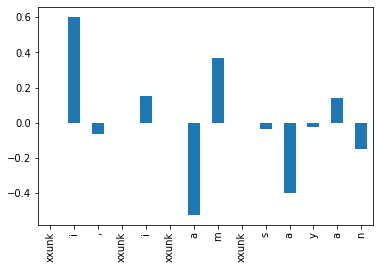

In [ ]:
# visualize as bar plot for each character
attributions.plot.bar()